# 1. 安装数据包

In [1]:
# 数据分析的核心库

import sys
import math
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from pandas import datetime
import random
# 时间序列处理
from datetime import datetime
from dateutil.parser import parse as dt_parse
# 正则库
import re
# os库
from os import listdir
# NLTK自然语言处理库
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
# seaborn成对图矩阵生成
from seaborn import pairplot
# sklearn库的归一化、训练集测试集划分
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Keras LSTM
import tensorflow 
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model, layers, initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling1D, Flatten, Activation, GRU
from tensorflow.keras.layers import Multiply, Input,Dense, Dropout, Conv1D, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
# ARIMA 
import statsmodels.api as sm
import statsmodels.tsa as ts
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
import itertools as it
#from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
# sklearn MSE
from sklearn import metrics
from sklearn.metrics import mean_squared_error
# GridSearchCV
from sklearn.model_selection import GridSearchCV

import os
 
os.environ["PATH"] += os.pathsep + 'C:/Users/Administrator/Thesis Programming/情感数据对股票模型预测的影响及神经网络设计/file'

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()


# 2. Pandas 显示设置

In [2]:
# 设置pandas的最大显示行数、列数和输出宽度
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_colwidth', 50)

# 3. 特征工程-模型预处理
## 数据清洗已经完成

In [3]:
#Define a series transformation func.by supervised learning
def series_to_supervised(data, n_in=1):
    # Default para.
    n_out=1
    dropnan=True
    # Fine tune this function. Note that data is the stock data of DataFrame time series 
    # ending with the close column (the column to be predicted)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Delete the irrelevant secondary state [t] column, leaving 
    # only the close [t] column to be predicted 
    # and the state feature [t-1] column of the previous time
    agg.drop(agg.columns[[x for x in range(data.shape[1], 2*data.shape[1]-1)]], axis=1, inplace=True)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
# 损失图绘制
def drawLossGraph(_history, title, num):
    
    #损失图绘制，观察最优epochs
    #:param _history: 训练历史
    #:param title: 图表标题
    #:param num: 图表编号
    #:return: 无
    
    plt.plot(_history.history['loss'], color='g', label='train')
    plt.plot(_history.history['val_loss'], color='r', label='test')
    plt.title('Fig'+num+'. '+title)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    # 保存于 new_test_file/result/
    savingPath = 'file/Fig'+num+'_'+title.replace(' ', '_')+'.png'
    plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    # 展示
    plt.show()

In [5]:
# 定义反归一化函数
def inverse_transform_col(_scaler, y, n_col):
    """
    对某个列进行反归一化处理的函数
    :param _scaler: sklearn归一化模型
    :param y: 需要反归一化的数据列
    :param n_col: y在归一化时所属的列编号
    :return: y的反归一化结果
    """
    y = y.copy()
    y -= _scaler.min_[n_col]
    y /= _scaler.scale_[n_col]
    return y

In [6]:
# 模型预测结果绘图函数
def ablation_exp(y1, y2, y3, y4, y5, y6, yTest,title, num):
    """
    预测结果图像绘制函数
    :param yTrain: 训练集结果
    :param yPredict: 验证集的预测结果
    :param yTest: 验证集的真实结果
    :param timelabels: x轴刻度标签
    :param title: 图表标题
    :param num: 图标编号
    :return: 无
    """
    #len_yTrain = yTrain.shape[0]
    #len_y = len_yTrain+yPredict.shape[0]
    # 测试集曲线绘制
    plt.plot(np.concatenate([yTest]), color='red', linestyle='dashed',label='test data')
    # 预测曲线绘制
    plt.plot(y1, color='seagreen', linestyle='dashed',label='LSTM')
    plt.plot(y2, color='mediumblue', linestyle='dashed',label='BILSTM')
    plt.plot(y3, color='darkviolet', linestyle='dashed',label='CNN_LSTM')
    plt.plot(y4, color='gold', linestyle='dashed',label='CNN_LSTM_AT')
    plt.plot(y5, color='slategrey', linestyle='dashed',label='CNN_BILSTM')
    plt.plot(y6, color='peru', linestyle='dashed',label='CNN_BILSTM_AT')
    
    # 标题和轴标签
    plt.title('Fig'+num+'. '+title)
    #plt.xlabel('date')
    plt.ylabel('close')
    plt.legend(loc=1, prop={'size': 6})
    # 刻度和刻度标签
    #xticks = [0,len_yTrain,len_y-1]
    #xtick_labels = [timelabels[x] for x in xticks]
    #plt.xticks(ticks=xticks, labels=xtick_labels, rotation=30)
    # 保存于 new_test_file/result/
    savingPath = 'file/ablation/Fig'+num+'_'+title.replace(' ', '_')+'.png'
    plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    # 展示
    plt.show()

# 4. 循环网络的搭建

## 4.1 情感数据影响下的LSTM v.s. 纯技术指标影响下的LSTM 

### 情感数据影响下的LSTM

In [7]:
# 读取数据
LSTMwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv', parse_dates=['Date'], index_col='Date').values
LSTMwithEmotion 

array([[3.16843323e+02, 3.48339996e+02, 3.14733337e+02, ...,
        4.88038517e-02, 7.20361750e-02, 3.41619995e+02],
       [3.41563324e+02, 3.64980011e+02, 3.33813324e+02, ...,
        7.68664389e-02, 8.51711347e-02, 3.39476654e+02],
       [3.46553345e+02, 3.56959991e+02, 3.43593323e+02, ...,
        5.11512681e-02, 8.35095523e-02, 3.45953339e+02],
       ...,
       [2.29500000e+02, 2.29820007e+02, 2.17250000e+02, ...,
        6.25000000e-02, 1.60282258e-01, 2.20190002e+02],
       [2.19800003e+02, 2.22929993e+02, 2.17779999e+02, ...,
        1.42857143e-02, 9.02331002e-02, 2.22039993e+02],
       [2.08279999e+02, 2.15550003e+02, 2.02000000e+02, ...,
        6.95105820e-02, 5.45836710e-02, 2.07279999e+02]])

In [8]:
# Normalization
# Feature_range from (0,1) in default
scaler_LSTM = MinMaxScaler(feature_range=(0,1))
# Fitting model
scaler_LSTM = scaler_LSTM.fit(LSTMwithEmotion)
# To normalize the data
LSTMwithEmotion = scaler_LSTM.fit_transform(LSTMwithEmotion)

# Partial arraries' demonstration
LSTMwithEmotion[:6,:]

array([[0.53504974, 0.66746527, 0.55351887, 1.        , 0.0976077 ,
        0.27013566, 0.6665528 ],
       [0.65651201, 0.75110585, 0.6472013 , 0.99145809, 0.15373288,
        0.31939176, 0.65609646],
       [0.68103059, 0.71079344, 0.69522093, 0.52462323, 0.10230254,
        0.31316082, 0.68769312],
       [0.72795466, 0.7277495 , 0.73355156, 0.30353597, 0.12098622,
        0.28073713, 0.75140664],
       [0.75014738, 0.78506798, 0.76466451, 0.35640165, 0.0975209 ,
        0.26562413, 0.81151011],
       [0.90651203, 0.95291869, 0.89463179, 0.44844756, 0.09171244,
        0.14868238, 0.97389986]])

In [9]:
# 使用series_to_supervised函数构建有监督数据集
LSTMwithEmotion = series_to_supervised(LSTMwithEmotion)
LSTMwithEmotion

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.535050,0.667465,0.553519,1.000000,0.097608,0.270136,0.666553,0.656096
2,0.656512,0.751106,0.647201,0.991458,0.153733,0.319392,0.656096,0.687693
3,0.681031,0.710793,0.695221,0.524623,0.102303,0.313161,0.687693,0.751407
4,0.727955,0.727750,0.733552,0.303536,0.120986,0.280737,0.751407,0.811510
5,0.750147,0.785068,0.764665,0.356402,0.097521,0.265624,0.811510,0.973900
...,...,...,...,...,...,...,...,...
175,0.063876,0.051270,0.063830,0.273399,0.094843,0.355849,0.056152,0.000000
176,0.078911,0.053833,0.010606,0.383393,0.000000,0.625000,0.000000,0.070056
177,0.010269,0.031717,0.036579,0.289135,0.400000,0.000000,0.070056,0.074154
178,0.105886,0.071728,0.074877,0.266095,0.125000,0.601058,0.074154,0.083179


In [10]:
# 必须规定ndarray的dtype为float32（默认float64），否则后续输入LSTM模型报错
LSTMwithEmotion = LSTMwithEmotion.values.astype(np.float32)
# 训练集:验证集=7:3
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(LSTMwithEmotion[:,:-1], LSTMwithEmotion[:,-1], test_size=0.3, shuffle=False)


In [11]:
#基于Keras函数的LSTM模型搭建
#重塑X_train和X_test：
# reshape input to be 3D [samples, timesteps, features]
X_train_LSTM = X_train_LSTM.reshape((X_train_LSTM.shape[0], 1, X_train_LSTM.shape[1]))
X_test_LSTM = X_test_LSTM.reshape((X_test_LSTM.shape[0], 1, X_test_LSTM.shape[1]))

print(len(X_train_LSTM))
print(len(X_test_LSTM))

125
54


In [12]:
X_train_LSTM.shape

(125, 1, 7)

In [13]:
# 建立LSTM神经网络模型并训练模型
def LSTM_Generator(Xtrain, Xtest, ytrain, ytest):
    """
    LSTM模型搭建函数
    :param Xtrain: 训练集属性
    :param Xtest: 测试集属性
    :param ytrain: 训练集标签
    :param ytest: 测试集标签
    :return: history,model（模型编译记录和模型）
    """
    # 搭建LSTM模型
    _model = Sequential()
    _model.add(LSTM(64,return_sequences=True,input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    _model.add(Dropout(0.2))
    """    
    _model.add(LSTM(64,return_sequences=True))
    _model.add(Dropout(0.2))
    
    _model.add(LSTM(64,return_sequences=True))
    _model.add(Dropout(0.2))
    
    _model.add(LSTM(64,return_sequences=True))
    _model.add(Dropout(0.2))
    """
    _model.add(Dense(1, activation='relu'))
    # 模型编译
    _model.compile(loss='mse', optimizer='adam')
    # 模型训练
    _history = _model.fit(Xtrain, ytrain, epochs=35, batch_size=20, validation_data=(Xtest, ytest), shuffle=False, verbose=1)
    return _history,_model
  
history_LSTM, model_LSTM = LSTM_Generator(X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM)

Train on 125 samples, validate on 54 samples
Epoch 1/35
125/125 [==============================] - 1s 11ms/sample - loss: 0.3029 - val_loss: 0.1036
Epoch 2/35
125/125 [==============================] - 0s 128us/sample - loss: 0.2361 - val_loss: 0.0689
Epoch 3/35
125/125 [==============================] - 0s 128us/sample - loss: 0.1706 - val_loss: 0.0421
Epoch 4/35
125/125 [==============================] - 0s 128us/sample - loss: 0.1176 - val_loss: 0.0237
Epoch 5/35
125/125 [==============================] - 0s 120us/sample - loss: 0.0761 - val_loss: 0.0130
Epoch 6/35
125/125 [==============================] - 0s 120us/sample - loss: 0.0477 - val_loss: 0.0089
Epoch 7/35
125/125 [==============================] - 0s 120us/sample - loss: 0.0273 - val_loss: 0.0091
Epoch 8/35
125/125 [==============================] - 0s 120us/sample - loss: 0.0216 - val_loss: 0.0112
Epoch 9/35
125/125 [==============================] - 0s 120us/sample - loss: 0.0158 - val_loss: 0.0130
Epoch 10/35
125/125 

In [14]:
# 绘制Loss曲线
#drawLossGraph(history_LSTM, title='LSTM_1Y Loss Graph for Stock Prices with Emotions', num='3')

In [15]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_LSTM = model_LSTM.predict(X_test_LSTM)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
LSTMwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_LSTM = LSTMwithEmotion.shape[1]-2
# 预测结果反归一化
inv_yPredict_LSTM = inverse_transform_col(scaler_LSTM, y_predict_LSTM, col_n_LSTM)
# 真实结果反归一化
inv_yTest_LSTM = inverse_transform_col(scaler_LSTM, y_test_LSTM, col_n_LSTM)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_LSTM = inverse_transform_col(scaler_LSTM, y_train_LSTM, col_n_LSTM)
# 绘图
#predictGraph(inv_yTrain_LSTM, inv_yPredict_LSTM, inv_yTest_LSTM, timelabels=LSTMwithEmotion['Date'].values, title='LSTM_1Y Prediction of Stock Prices with Emotions', num='4')


In [16]:
#print(model_LSTM.summary())

### 纯技术指标影响下的LSTM

In [17]:
# 创建标准化功能打包函数 
def formatData(sharePricesData):
    """
    模式化样本数据的函数
    :param sharePricesData: 样本数据的DataFrame
    :return: X_train, X_test, y_train, y_test, scaler
    """
    # 归一化
    _scaler = MinMaxScaler()
    _scaler = _scaler.fit(sharePricesData)
    sharePricesData = _scaler.fit_transform(sharePricesData)
    # 构建有监督数据集
    sharePricesData = series_to_supervised(sharePricesData)
    # dtype为float32
    sharePricesData = sharePricesData.values.astype(np.float32)
    # 训练集和验证集的划分
    _X_train, _X_test, _y_train, _y_test = train_test_split(sharePricesData[:,:-1], sharePricesData[:,-1], test_size=0.3, shuffle=False)
    # reshape input
    _X_train = _X_train.reshape((_X_train.shape[0], 1, _X_train.shape[1]))
    _X_test = _X_test.reshape((_X_test.shape[0], 1, _X_test.shape[1]))
    return _X_train, _X_test, _y_train, _y_test, _scaler

In [18]:
# 批量反归一化
def invTransformMulti(_scaler, _y_predict, _y_test, _y_train, _col_n):
    
    _inv_yPredict = inverse_transform_col(_scaler, _y_predict, _col_n)
    _inv_yTest = inverse_transform_col(_scaler, _y_test, _col_n)
    _inv_yTrain = inverse_transform_col(_scaler, _y_train, _col_n)
    return _inv_yPredict, _inv_yTest, _inv_yTrain

In [19]:
# 读取数据
sharePricesTSLA_pureLSTM = pd.read_csv('file/one_year/one_result/TSLA_stockprice_1Y.csv', parse_dates=['Date'], index_col='Date').values
# 标准化数据输入
X_train_pureLSTM, X_test_pureLSTM, y_train_pureLSTM, y_test_pureLSTM, scaler_pureLSTM = formatData(sharePricesTSLA_pureLSTM)


In [20]:
print(len(X_train_pureLSTM))
print(len(X_test_pureLSTM))

175
75


In [21]:
# 建模
history_pureLSTM, model_pureLSTM = LSTM_Generator(X_train_pureLSTM, X_test_pureLSTM, y_train_pureLSTM, y_test_pureLSTM)


Train on 175 samples, validate on 75 samples
Epoch 1/35
175/175 [==============================] - 1s 7ms/sample - loss: 0.2322 - val_loss: 0.0663
Epoch 2/35
175/175 [==============================] - 0s 108us/sample - loss: 0.1634 - val_loss: 0.0412
Epoch 3/35
175/175 [==============================] - 0s 108us/sample - loss: 0.1081 - val_loss: 0.0231
Epoch 4/35
175/175 [==============================] - 0s 108us/sample - loss: 0.0692 - val_loss: 0.0119
Epoch 5/35
175/175 [==============================] - 0s 103us/sample - loss: 0.0392 - val_loss: 0.0071
Epoch 6/35
175/175 [==============================] - 0s 114us/sample - loss: 0.0229 - val_loss: 0.0068
Epoch 7/35
175/175 [==============================] - 0s 108us/sample - loss: 0.0187 - val_loss: 0.0085
Epoch 8/35
175/175 [==============================] - 0s 103us/sample - loss: 0.0140 - val_loss: 0.0098
Epoch 9/35
175/175 [==============================] - 0s 103us/sample - loss: 0.0127 - val_loss: 0.0096
Epoch 10/35
175/175 [

In [22]:
# 纯技术指标的LSTM损失函数绘图
#drawLossGraph(history_pureLSTM, title='LSTM_1Y Loss Graph for Stock Prices without Emotions', num='5')

In [23]:
# 预测
y_predict_pureLSTM = model_pureLSTM.predict(X_test_pureLSTM)[:,0]
# 反归一化
sharePricesTSLA_pureLSTM = pd.read_csv('file/one_year/one_result/TSLA_stockprice_1Y.csv')
col_n_pureLSTM = sharePricesTSLA_pureLSTM.shape[1]-2
inv_yPredict_pureLSTM, inv_yTest_pureLSTM, inv_yTrain_pureLSTM = invTransformMulti(scaler_pureLSTM, y_predict_pureLSTM, y_test_pureLSTM, y_train_pureLSTM, col_n_pureLSTM)
# 绘图
#predictGraph(inv_yTrain_pureLSTM, inv_yPredict_pureLSTM, inv_yTest_pureLSTM, timelabels=sharePricesTSLA_pureLSTM['Date'].values, title='LSTM_1Y Prediction of Stock Prices without Emotions', num='6')


In [24]:
#print(model_pureLSTM.summary())

### MSE MAE R_square 估值

In [25]:
# 含情感数据的LSTM---输出MSE MAE R方评估值
MSE_error_LSTM = mean_squared_error(inv_yTest_LSTM, inv_yPredict_LSTM)
print('The Mean Squared Error is {}'.format(MSE_error_LSTM))
print('The Root Mean Squared Error is:')
print(math.sqrt(MSE_error_LSTM))
print('The Mean Absolute Error is:',mean_absolute_error(inv_yTest_LSTM, inv_yPredict_LSTM))
print('R Square is {}'.format(r2_score(inv_yTest_LSTM, inv_yPredict_LSTM)))

The Mean Squared Error is 170.9425048828125
The Root Mean Squared Error is:
13.074498265050652
The Mean Absolute Error is: 10.725941
R Square is 0.8170672840763358


In [26]:
# 纯技术指标影响的LSTM——输出MSE MAE R方评估值
MSE_error_pureLSTM = mean_squared_error(inv_yTest_pureLSTM, inv_yPredict_pureLSTM)
print('The Mean Squared Error is {}'.format(MSE_error_pureLSTM))
print('The Root Mean Squared Error is:')
print(math.sqrt(MSE_error_pureLSTM))
print('The Mean Absolute Error is:',mean_absolute_error(inv_yTest_pureLSTM, inv_yPredict_pureLSTM))
print('R Square is {}'.format(r2_score(inv_yTest_pureLSTM, inv_yPredict_pureLSTM)))

The Mean Squared Error is 114.12420654296875
The Root Mean Squared Error is:
10.682893172870763
The Mean Absolute Error is: 8.855694
R Square is 0.8788087112160152


In [27]:
MSE_error_LSTM = mean_squared_error(inv_yTest_LSTM, inv_yPredict_LSTM)
RMSE_LSTM = math.sqrt(MSE_error_LSTM)
MAE_LSTM = mean_absolute_error(inv_yTest_LSTM, inv_yPredict_LSTM)


In [28]:
MSE_error_pureLSTM = mean_squared_error(inv_yTest_pureLSTM, inv_yPredict_pureLSTM)
RMSE_pureLSTM = math.sqrt(MSE_error_pureLSTM)
MAE_pureLSTM = mean_absolute_error(inv_yTest_pureLSTM, inv_yPredict_pureLSTM)


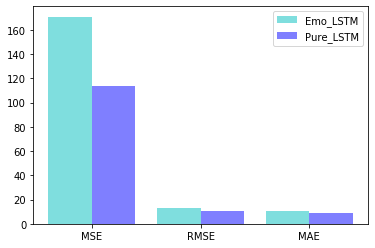

In [29]:
# 绘制估值比较图
x = np.arange(3)
emo_lstm = [MSE_error_LSTM,RMSE_LSTM,MAE_LSTM]
pure_lstm = [MSE_error_pureLSTM,RMSE_pureLSTM,MAE_pureLSTM]
 
bar_width = 0.4
tick_label = ["MSE", "RMSE", "MAE"]
plt.bar(x, emo_lstm, align="center", color="c",width=bar_width,label="Emo_LSTM",alpha=0.5)
plt.bar(x+bar_width, pure_lstm, align="center",color="b",width=bar_width,label="Pure_LSTM",alpha=0.5)
plt.xticks(x+bar_width/2, tick_label)
plt.legend()
plt.show()

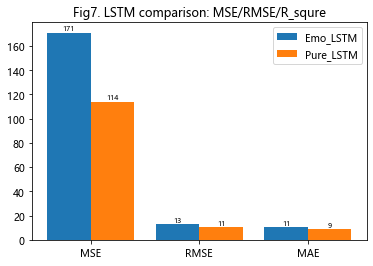

In [30]:
# 绘制估值比较图
#import matplotlib
#import matplotlib.pyplot as plt
#import numpy as np

def drawHistogram(title, num):
    matplotlib.rc("font", family='MicroSoft YaHei')
    list1 = np.array([MSE_error_LSTM,RMSE_LSTM,MAE_LSTM])   # 柱状图第一组数据
    list2 = np.array([MSE_error_pureLSTM,RMSE_pureLSTM,MAE_pureLSTM])   # 柱状图第二组数据
    length = len(list1)
    x = np.arange(length)   # 横坐标范围
    x_label = ["MSE", "RMSE", "MAE"]

    plt.figure()
    total_width, n = 0.8, 2   # 柱状图总宽度，有几组数据
    width = total_width / n   # 单个柱状图的宽度
    x1 = x - width / 2   # 第一组数据柱状图横坐标起始位置
    x2 = x1 + width   # 第二组数据柱状图横坐标起始位置
    # 标题
    plt.title('Fig'+num+'. '+title)

    
    # plt.xlabel("星期")   # 横坐标label 此处可以不添加
    plt.bar(x1, list1, width=width, label="Emo_LSTM")
    plt.bar(x2, list2, width=width, label="Pure_LSTM")
    for a, b in zip(x1, list1):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=7)

    for a, b in zip(x2, list2):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=7)

    plt.xticks(x, x_label)   
    plt.legend()   # 给出图例
    
    # 保存于 file/
    #savingPath = 'file/Fig'+num+'_'+title.replace(' ', '_')+'.png'
    #plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    drawHistogram(title = 'LSTM comparison: MSE/RMSE/R_squre', num = '7')


## 4.2 含情感数据的股票模型搭建

### 4.2.1 含情感数据的BI-LSTM建模及预测

In [31]:
# 读取数据
BIwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv', parse_dates=['Date'], index_col='Date').values
BIwithEmotion

array([[3.16843323e+02, 3.48339996e+02, 3.14733337e+02, ...,
        4.88038517e-02, 7.20361750e-02, 3.41619995e+02],
       [3.41563324e+02, 3.64980011e+02, 3.33813324e+02, ...,
        7.68664389e-02, 8.51711347e-02, 3.39476654e+02],
       [3.46553345e+02, 3.56959991e+02, 3.43593323e+02, ...,
        5.11512681e-02, 8.35095523e-02, 3.45953339e+02],
       ...,
       [2.29500000e+02, 2.29820007e+02, 2.17250000e+02, ...,
        6.25000000e-02, 1.60282258e-01, 2.20190002e+02],
       [2.19800003e+02, 2.22929993e+02, 2.17779999e+02, ...,
        1.42857143e-02, 9.02331002e-02, 2.22039993e+02],
       [2.08279999e+02, 2.15550003e+02, 2.02000000e+02, ...,
        6.95105820e-02, 5.45836710e-02, 2.07279999e+02]])

In [32]:
# 生成归一化容器
# feature_range参数沿用默认(0,1)
scaler_BI = MinMaxScaler(feature_range=(0,1))
# 训练模型
scaler_BI = scaler_BI.fit(BIwithEmotion)
# 归一化
BIwithEmotion = scaler_BI.fit_transform(BIwithEmotion)

# 部分结果展示
BIwithEmotion[:6,:]

array([[0.53504974, 0.66746527, 0.55351887, 1.        , 0.0976077 ,
        0.27013566, 0.6665528 ],
       [0.65651201, 0.75110585, 0.6472013 , 0.99145809, 0.15373288,
        0.31939176, 0.65609646],
       [0.68103059, 0.71079344, 0.69522093, 0.52462323, 0.10230254,
        0.31316082, 0.68769312],
       [0.72795466, 0.7277495 , 0.73355156, 0.30353597, 0.12098622,
        0.28073713, 0.75140664],
       [0.75014738, 0.78506798, 0.76466451, 0.35640165, 0.0975209 ,
        0.26562413, 0.81151011],
       [0.90651203, 0.95291869, 0.89463179, 0.44844756, 0.09171244,
        0.14868238, 0.97389986]])

In [33]:
#使用series_to_supervised函数构建有监督数据集
BIwithEmotion = series_to_supervised(BIwithEmotion)
BIwithEmotion

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.535050,0.667465,0.553519,1.000000,0.097608,0.270136,0.666553,0.656096
2,0.656512,0.751106,0.647201,0.991458,0.153733,0.319392,0.656096,0.687693
3,0.681031,0.710793,0.695221,0.524623,0.102303,0.313161,0.687693,0.751407
4,0.727955,0.727750,0.733552,0.303536,0.120986,0.280737,0.751407,0.811510
5,0.750147,0.785068,0.764665,0.356402,0.097521,0.265624,0.811510,0.973900
...,...,...,...,...,...,...,...,...
175,0.063876,0.051270,0.063830,0.273399,0.094843,0.355849,0.056152,0.000000
176,0.078911,0.053833,0.010606,0.383393,0.000000,0.625000,0.000000,0.070056
177,0.010269,0.031717,0.036579,0.289135,0.400000,0.000000,0.070056,0.074154
178,0.105886,0.071728,0.074877,0.266095,0.125000,0.601058,0.074154,0.083179


In [34]:
# 必须规定ndarray的dtype为float32（默认float64），否则后续输入LSTM模型报错
BIwithEmotion = BIwithEmotion.values.astype(np.float32)
# 训练集:验证集=7:3
X_train_BI, X_test_BI, y_train_BI, y_test_BI = train_test_split(BIwithEmotion[:,:-1], BIwithEmotion[:,-1], test_size=0.3, shuffle=False)


In [35]:
#基于Keras函数的BILSTM模型搭建
#重塑X_train和X_test：
# reshape input to be 3D [samples, timesteps, features]
X_train_BI = X_train_BI.reshape((X_train_BI.shape[0], 1, X_train_BI.shape[1]))
X_test_BI = X_test_BI.reshape((X_test_BI.shape[0], 1, X_test_BI.shape[1]))

print(len(X_train_BI))
print(len(X_test_BI))

125
54


In [36]:
def BILSTM_Generator(Xtrain, Xtest, ytrain, ytest):
    """
    LSTM模型搭建函数
    :param Xtrain: 训练集属性
    :param Xtest: 测试集属性
    :param ytrain: 训练集标签
    :param ytest: 测试集标签
    :return: history,model（模型编译记录和模型）
    """
    # 搭建BILSTM模型
    _model = Sequential()
    _model.add(Bidirectional(LSTM(64,return_sequences=True,input_shape=(Xtrain.shape[1], Xtrain.shape[2]))))
    _model.add(Dropout(0.2))
    
    _model.add(Dense(1, activation='relu'))
    # 模型编译
    _model.compile(loss='mse', optimizer='adam')
    # 模型训练
    _history = _model.fit(Xtrain, ytrain, epochs=35, batch_size=20, validation_data=(Xtest, ytest), shuffle=False, verbose=1)
    return _history,_model
  
history_BI, model_BI = BILSTM_Generator(X_train_BI, X_test_BI, y_train_BI, y_test_BI)

Train on 125 samples, validate on 54 samples
Epoch 1/35
125/125 [==============================] - 2s 16ms/sample - loss: 0.2955 - val_loss: 0.0795
Epoch 2/35
125/125 [==============================] - 0s 152us/sample - loss: 0.1931 - val_loss: 0.0400
Epoch 3/35
125/125 [==============================] - 0s 136us/sample - loss: 0.1130 - val_loss: 0.0167
Epoch 4/35
125/125 [==============================] - 0s 136us/sample - loss: 0.0585 - val_loss: 0.0083
Epoch 5/35
125/125 [==============================] - 0s 136us/sample - loss: 0.0317 - val_loss: 0.0103
Epoch 6/35
125/125 [==============================] - 0s 136us/sample - loss: 0.0167 - val_loss: 0.0154
Epoch 7/35
125/125 [==============================] - 0s 136us/sample - loss: 0.0153 - val_loss: 0.0174
Epoch 8/35
125/125 [==============================] - 0s 136us/sample - loss: 0.0137 - val_loss: 0.0155
Epoch 9/35
125/125 [==============================] - 0s 128us/sample - loss: 0.0134 - val_loss: 0.0125
Epoch 10/35
125/125 

In [37]:
#绘制BILSTM损失图
#drawLossGraph(history_BI, title='BILSTM_1Y Loss Graph for Stock Prices with Emotions', num='8')

In [38]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_BI = model_BI.predict(X_test_BI)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
BIwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_BI = BIwithEmotion.shape[1]-2
# 预测结果反归一化
inv_yPredict_BI = inverse_transform_col(scaler_BI, y_predict_BI, col_n_BI)
# 真实结果反归一化
inv_yTest_BI = inverse_transform_col(scaler_BI, y_test_BI, col_n_BI)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_BI = inverse_transform_col(scaler_BI, y_train_BI, col_n_BI)
# 绘图
#predictGraph(inv_yTrain_BI, inv_yPredict_BI, inv_yTest_BI, timelabels=BIwithEmotion['Date'].values, title='BILSTM_1Y Prediction of Stock Prices with Emotions', num='9')


In [39]:
# 输出MSE MAE R方评估值
MSE_error_BI = mean_squared_error(inv_yTest_BI, inv_yPredict_BI)
RMSE_BI = math.sqrt(MSE_error_BI)
MAE_BI = mean_absolute_error(inv_yTest_BI, inv_yPredict_BI)
R_square_BI = r2_score(inv_yTest_BI, inv_yPredict_BI)
print('The Mean Squared Error is {}'.format(MSE_error_BI))
print('The Root Mean Squared Error is:')
print(RMSE_BI)
print('The Mean Absolute Error is:',MAE_BI)
print('R Square is {}'.format(R_square_BI))

The Mean Squared Error is 137.41558837890625
The Root Mean Squared Error is:
11.72243952336314
The Mean Absolute Error is: 9.352887
R Square is 0.8529458606367669


In [40]:
#print(model_BI.summary())

### 4.2.2 建立CNN_LSTM机制的预测模型

In [41]:
# 读取数据
CLwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv', parse_dates=['Date'], index_col='Date').values
CLwithEmotion

array([[3.16843323e+02, 3.48339996e+02, 3.14733337e+02, ...,
        4.88038517e-02, 7.20361750e-02, 3.41619995e+02],
       [3.41563324e+02, 3.64980011e+02, 3.33813324e+02, ...,
        7.68664389e-02, 8.51711347e-02, 3.39476654e+02],
       [3.46553345e+02, 3.56959991e+02, 3.43593323e+02, ...,
        5.11512681e-02, 8.35095523e-02, 3.45953339e+02],
       ...,
       [2.29500000e+02, 2.29820007e+02, 2.17250000e+02, ...,
        6.25000000e-02, 1.60282258e-01, 2.20190002e+02],
       [2.19800003e+02, 2.22929993e+02, 2.17779999e+02, ...,
        1.42857143e-02, 9.02331002e-02, 2.22039993e+02],
       [2.08279999e+02, 2.15550003e+02, 2.02000000e+02, ...,
        6.95105820e-02, 5.45836710e-02, 2.07279999e+02]])

In [42]:
# 生成归一化容器
# feature_range参数沿用默认(0,1)
scaler_CL = MinMaxScaler(feature_range=(0,1))
# 训练模型
scaler_CL = scaler_CL.fit(CLwithEmotion)
# 归一化
CLwithEmotion = scaler_CL.fit_transform(CLwithEmotion)

In [43]:
# 部分结果展示
CLwithEmotion[:6,:]

array([[0.53504974, 0.66746527, 0.55351887, 1.        , 0.0976077 ,
        0.27013566, 0.6665528 ],
       [0.65651201, 0.75110585, 0.6472013 , 0.99145809, 0.15373288,
        0.31939176, 0.65609646],
       [0.68103059, 0.71079344, 0.69522093, 0.52462323, 0.10230254,
        0.31316082, 0.68769312],
       [0.72795466, 0.7277495 , 0.73355156, 0.30353597, 0.12098622,
        0.28073713, 0.75140664],
       [0.75014738, 0.78506798, 0.76466451, 0.35640165, 0.0975209 ,
        0.26562413, 0.81151011],
       [0.90651203, 0.95291869, 0.89463179, 0.44844756, 0.09171244,
        0.14868238, 0.97389986]])

In [44]:
# 使用series_to_supervised函数构建有监督数据集
CLwithEmotion = series_to_supervised(CLwithEmotion)
CLwithEmotion

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.535050,0.667465,0.553519,1.000000,0.097608,0.270136,0.666553,0.656096
2,0.656512,0.751106,0.647201,0.991458,0.153733,0.319392,0.656096,0.687693
3,0.681031,0.710793,0.695221,0.524623,0.102303,0.313161,0.687693,0.751407
4,0.727955,0.727750,0.733552,0.303536,0.120986,0.280737,0.751407,0.811510
5,0.750147,0.785068,0.764665,0.356402,0.097521,0.265624,0.811510,0.973900
...,...,...,...,...,...,...,...,...
175,0.063876,0.051270,0.063830,0.273399,0.094843,0.355849,0.056152,0.000000
176,0.078911,0.053833,0.010606,0.383393,0.000000,0.625000,0.000000,0.070056
177,0.010269,0.031717,0.036579,0.289135,0.400000,0.000000,0.070056,0.074154
178,0.105886,0.071728,0.074877,0.266095,0.125000,0.601058,0.074154,0.083179


In [45]:
# 必须规定ndarray的dtype为float32（默认float64），否则后续输入LSTM模型报错
CLwithEmotion = CLwithEmotion.values.astype(np.float32)

future_days = 0
y = CLwithEmotion[future_days:, 6]
print(y.shape)
X = CLwithEmotion[:len(CLwithEmotion) - future_days, :]
print(X.shape)

(179,)
(179, 8)


In [46]:
#time_steps = 10
time_steps = 5
X_new = np.zeros((X.shape[0] - time_steps + 1, time_steps, X.shape[1]))
y_new = np.zeros((y.shape[0] - time_steps + 1, 1))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :] = X[ix + jx, :]
    y_new[ix] = y[ix + time_steps -1]
print(X_new.shape, y_new.shape)

(175, 5, 8) (175, 1)


In [47]:
split = int(0.7 * CLwithEmotion.shape[0])
X_train_CL = X_new[:split]
X_test_CL = X_new[split:]

y_train_CL = y_new[:split]
y_test_CL = y_new[split:]

print(X_train_CL.shape, y_train_CL.shape)
print(X_test_CL.shape, y_test_CL.shape)

(125, 5, 8) (125, 1)
(50, 5, 8) (50, 1)


In [48]:
print(X_train_CL.shape[1], X_train_CL.shape[2])

5 8


In [49]:
def CNN_LSTM_Generator(Xtrain, Xtest, ytrain, ytest):
    """
    LSTM模型搭建函数
    :param Xtrain: 训练集属性
    :param Xtest: 测试集属性
    :param ytrain: 训练集标签
    :param ytest: 测试集标签
    :return: history,model（模型编译记录和模型）
    """
   # 搭建模型
    _model = Sequential()
    
    _model.add(Conv1D(32, 1, input_shape=(Xtrain.shape[1], Xtrain.shape[2]), padding="same"))
    #_model.add(MaxPooling1D(pool_size=2))
    _model.add(Dropout(0.2))
    _model.add(LSTM(32, return_sequences=True))
    _model.add(Dropout(0.2))
    #_model.add(Conv1D(16, 3, padding="same"))
    #_model.add(MaxPooling1D(pool_size=2))
    _model.add(Flatten())
    _model.add(Dense(units=1))
    _model.add(Activation('linear'))
    
    # 模型编译
    _model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae'])
    # 模型训练
    es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    _history = _model.fit(Xtrain, ytrain, batch_size=20, epochs=50, validation_data=(Xtest, ytest), callbacks=[es_cb], verbose=2)
    return _history,_model
  
history_CL, model_CL = CNN_LSTM_Generator(X_train_CL, X_test_CL, y_train_CL, y_test_CL)

Train on 125 samples, validate on 50 samples
Epoch 1/50
125/125 - 1s - loss: 0.1879 - acc: 0.0000e+00 - mae: 0.3730 - val_loss: 0.0135 - val_acc: 0.0200 - val_mae: 0.0997
Epoch 2/50
125/125 - 0s - loss: 0.0268 - acc: 0.0080 - mae: 0.1333 - val_loss: 0.0220 - val_acc: 0.0200 - val_mae: 0.1355
Epoch 3/50
125/125 - 0s - loss: 0.0388 - acc: 0.0080 - mae: 0.1629 - val_loss: 0.0140 - val_acc: 0.0200 - val_mae: 0.1046
Epoch 4/50
125/125 - 0s - loss: 0.0187 - acc: 0.0080 - mae: 0.1100 - val_loss: 0.0039 - val_acc: 0.0200 - val_mae: 0.0504
Epoch 5/50
125/125 - 0s - loss: 0.0163 - acc: 0.0080 - mae: 0.0978 - val_loss: 0.0044 - val_acc: 0.0200 - val_mae: 0.0522
Epoch 6/50
125/125 - 0s - loss: 0.0151 - acc: 0.0080 - mae: 0.0944 - val_loss: 0.0037 - val_acc: 0.0200 - val_mae: 0.0486
Epoch 7/50
125/125 - 0s - loss: 0.0160 - acc: 0.0080 - mae: 0.1011 - val_loss: 0.0040 - val_acc: 0.0200 - val_mae: 0.0506
Epoch 8/50
125/125 - 0s - loss: 0.0146 - acc: 0.0080 - mae: 0.0950 - val_loss: 0.0044 - val_acc: 

In [50]:
#drawLossGraph(history_CL, title='CNN_LSTM_1Y Loss Graph for Stock Prices with Emotions', num='10')

In [51]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_CL = model_CL.predict(X_test_CL)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
CLwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_CL = CLwithEmotion.shape[1]-2
# 预测结果反归一化
inv_yPredict_CL = inverse_transform_col(scaler_CL, y_predict_CL, col_n_CL)
# 真实结果反归一化
inv_yTest_CL = inverse_transform_col(scaler_CL, y_test_CL, col_n_CL)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_CL = inverse_transform_col(scaler_CL, y_train_CL, col_n_CL)
# 绘图
#predictGraph(inv_yTrain_CL, inv_yPredict_CL, inv_yTest_CL, timelabels=CLwithEmotion['Date'].values, title='CNN_LSTM_1Y Prediction of Stock Prices with Emotions', num='11')

In [52]:
# 输出MSE MAE R方评估值
MSE_error_CL = mean_squared_error(inv_yTest_CL, inv_yPredict_CL)
RMSE_CL = math.sqrt(MSE_error_CL)
MAE_CL = mean_absolute_error(inv_yTest_CL, inv_yPredict_CL)
R_square_CL = r2_score(inv_yTest_CL, inv_yPredict_CL)
print('The Mean Squared Error is {}'.format(MSE_error_CL))
print('The Root Mean Squared Error is:')
print(RMSE_CL)
print('The Mean Absolute Error is:',MAE_CL)
print('R Square is {}'.format(R_square_CL))

The Mean Squared Error is 129.26024424372713
The Root Mean Squared Error is:
11.369267533299018
The Mean Absolute Error is: 8.583253194359461
R Square is 0.848943271252421


In [53]:
#print(model_CL.summary())

### 4.2.3 在CNN_LSTM机制中添加Attention机制的预测模型

In [54]:
def CNN_LSTM_AT_Generator(Xtrain, Xtest, ytrain, ytest):
    """
    LSTM模型搭建函数
    :param Xtrain: 训练集属性
    :param Xtest: 测试集属性
    :param ytrain: 训练集标签
    :param ytest: 测试集标签
    :return: history,model（模型编译记录和模型）
    """
   # 搭建模型
    inputs = Input(shape = (Xtrain.shape[1], Xtrain.shape[2]))   
    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu', padding="same")(inputs)
    #x = MaxPooling1D(pool_size = 2)(x)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=True,activation='relu')(x)
    #x = Dropout(0.2)(x)
    
    #x = Conv1D(filters = 64, kernel_size = 3, activation = 'relu', padding="same")(x)
    #x = MaxPooling1D(pool_size = 2)(x)
    #x = Dropout(0.2)(x)
    #x = LSTM(128, return_sequences=True,activation='relu')(x)
    previous_out = Dropout(0.2)(x)
    
    
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(64, activation='sigmoid', name='attention_vec')(previous_out)

    attention_mul =Multiply()([previous_out, attention_probs])
    
    attention_mul = Flatten()(attention_mul)

    output = Dense(1, activation='sigmoid')(attention_mul)
    _model = Model(inputs=inputs, outputs=output)
    
    # 模型编译
    _model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae'])
    # 模型训练
    es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    _history = _model.fit(Xtrain, ytrain, batch_size=20, epochs=50, validation_data=(Xtest, ytest), callbacks=[es_cb], verbose=2)
    return _history,_model
  
history_CLA, model_CLA = CNN_LSTM_AT_Generator(X_train_CL, X_test_CL, y_train_CL, y_test_CL)

Train on 125 samples, validate on 50 samples
Epoch 1/50
125/125 - 1s - loss: 0.0595 - acc: 0.0080 - mae: 0.2069 - val_loss: 0.0514 - val_acc: 0.0000e+00 - val_mae: 0.1792
Epoch 2/50
125/125 - 0s - loss: 0.0547 - acc: 0.0080 - mae: 0.1983 - val_loss: 0.0545 - val_acc: 0.0000e+00 - val_mae: 0.1924
Epoch 3/50
125/125 - 0s - loss: 0.0505 - acc: 0.0080 - mae: 0.1886 - val_loss: 0.0569 - val_acc: 0.0200 - val_mae: 0.2039
Epoch 4/50
125/125 - 0s - loss: 0.0464 - acc: 0.0080 - mae: 0.1766 - val_loss: 0.0537 - val_acc: 0.0200 - val_mae: 0.1998
Epoch 5/50
125/125 - 0s - loss: 0.0409 - acc: 0.0080 - mae: 0.1656 - val_loss: 0.0421 - val_acc: 0.0200 - val_mae: 0.1667
Epoch 6/50
125/125 - 0s - loss: 0.0348 - acc: 0.0080 - mae: 0.1525 - val_loss: 0.0335 - val_acc: 0.0200 - val_mae: 0.1420
Epoch 7/50
125/125 - 0s - loss: 0.0274 - acc: 0.0080 - mae: 0.1370 - val_loss: 0.0212 - val_acc: 0.0200 - val_mae: 0.1016
Epoch 8/50
125/125 - 0s - loss: 0.0195 - acc: 0.0080 - mae: 0.1170 - val_loss: 0.0120 - val_a

In [55]:
#drawLossGraph(history_CLA, title='CNN_LSTM_AT_1Y Loss Graph for Stock Prices with Emotions', num='12')

In [56]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_CLA = model_CLA.predict(X_test_CL)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
CLAwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_CLA = CLAwithEmotion.shape[1]-2
# 预测结果反归一化
inv_yPredict_CLA = inverse_transform_col(scaler_CL, y_predict_CLA, col_n_CLA)
# 真实结果反归一化
inv_yTest_CLA = inverse_transform_col(scaler_CL, y_test_CL, col_n_CLA)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_CLA = inverse_transform_col(scaler_CL, y_train_CL, col_n_CLA)
# 绘图
#predictGraph(inv_yTrain_CLA, inv_yPredict_CLA, inv_yTest_CLA, timelabels=CLAwithEmotion['Date'].values, title='CNN_LSTM_AT_1Y Prediction of Stock Prices with Emotions', num='13')

In [57]:
# 输出MSE MAE R方评估值
MSE_error_CLA = mean_squared_error(inv_yTest_CLA, inv_yPredict_CLA)
RMSE_CLA = math.sqrt(MSE_error_CLA)
MAE_CLA = mean_absolute_error(inv_yTest_CLA, inv_yPredict_CLA)
R_square_CLA = r2_score(inv_yTest_CLA, inv_yPredict_CLA)
print('The Mean Squared Error is {}'.format(MSE_error_CLA))
print('The Root Mean Squared Error is:')
print(RMSE_CLA)
print('The Mean Absolute Error is:',MAE_CLA)
print('R Square is {}'.format(R_square_CLA))

The Mean Squared Error is 89.4685466623936
The Root Mean Squared Error is:
9.458781457587103
The Mean Absolute Error is: 6.953910885698372
R Square is 0.8954448363942561


### 4.2.4 建立CNN_BILSTM机制的预测模型

In [58]:
# 读取数据
CBwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv', parse_dates=['Date'], index_col='Date').values
CBwithEmotion

array([[3.16843323e+02, 3.48339996e+02, 3.14733337e+02, ...,
        4.88038517e-02, 7.20361750e-02, 3.41619995e+02],
       [3.41563324e+02, 3.64980011e+02, 3.33813324e+02, ...,
        7.68664389e-02, 8.51711347e-02, 3.39476654e+02],
       [3.46553345e+02, 3.56959991e+02, 3.43593323e+02, ...,
        5.11512681e-02, 8.35095523e-02, 3.45953339e+02],
       ...,
       [2.29500000e+02, 2.29820007e+02, 2.17250000e+02, ...,
        6.25000000e-02, 1.60282258e-01, 2.20190002e+02],
       [2.19800003e+02, 2.22929993e+02, 2.17779999e+02, ...,
        1.42857143e-02, 9.02331002e-02, 2.22039993e+02],
       [2.08279999e+02, 2.15550003e+02, 2.02000000e+02, ...,
        6.95105820e-02, 5.45836710e-02, 2.07279999e+02]])

In [59]:
# 生成归一化容器
# feature_range参数沿用默认(0,1)
scaler_CB = MinMaxScaler(feature_range=(0,1))
# 训练模型
scaler_CB = scaler_CB.fit(CBwithEmotion)
# 归一化
CBwithEmotion = scaler_CB.fit_transform(CBwithEmotion)
# 部分结果展示
CBwithEmotion[:6,:]

array([[0.53504974, 0.66746527, 0.55351887, 1.        , 0.0976077 ,
        0.27013566, 0.6665528 ],
       [0.65651201, 0.75110585, 0.6472013 , 0.99145809, 0.15373288,
        0.31939176, 0.65609646],
       [0.68103059, 0.71079344, 0.69522093, 0.52462323, 0.10230254,
        0.31316082, 0.68769312],
       [0.72795466, 0.7277495 , 0.73355156, 0.30353597, 0.12098622,
        0.28073713, 0.75140664],
       [0.75014738, 0.78506798, 0.76466451, 0.35640165, 0.0975209 ,
        0.26562413, 0.81151011],
       [0.90651203, 0.95291869, 0.89463179, 0.44844756, 0.09171244,
        0.14868238, 0.97389986]])

In [60]:
# 使用series_to_supervised函数构建有监督数据集
CBwithEmotion = series_to_supervised(CBwithEmotion)
CBwithEmotion

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.535050,0.667465,0.553519,1.000000,0.097608,0.270136,0.666553,0.656096
2,0.656512,0.751106,0.647201,0.991458,0.153733,0.319392,0.656096,0.687693
3,0.681031,0.710793,0.695221,0.524623,0.102303,0.313161,0.687693,0.751407
4,0.727955,0.727750,0.733552,0.303536,0.120986,0.280737,0.751407,0.811510
5,0.750147,0.785068,0.764665,0.356402,0.097521,0.265624,0.811510,0.973900
...,...,...,...,...,...,...,...,...
175,0.063876,0.051270,0.063830,0.273399,0.094843,0.355849,0.056152,0.000000
176,0.078911,0.053833,0.010606,0.383393,0.000000,0.625000,0.000000,0.070056
177,0.010269,0.031717,0.036579,0.289135,0.400000,0.000000,0.070056,0.074154
178,0.105886,0.071728,0.074877,0.266095,0.125000,0.601058,0.074154,0.083179


In [61]:
# 必须规定ndarray的dtype为float32（默认float64），否则后续输入模型报错
CBwithEmotion = CBwithEmotion.values.astype(np.float32)

In [62]:
future_days = 0
y = CBwithEmotion[future_days:, 6]
print(y.shape)
X = CBwithEmotion[:len(CBwithEmotion) - future_days, :]
print(X.shape)

(179,)
(179, 8)


In [63]:
#time_steps = 10
time_steps = 5
X_new = np.zeros((X.shape[0] - time_steps + 1, time_steps, X.shape[1]))
y_new = np.zeros((y.shape[0] - time_steps + 1, 1))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :] = X[ix + jx, :]
    y_new[ix] = y[ix + time_steps -1]
print(X_new.shape, y_new.shape)

(175, 5, 8) (175, 1)


In [64]:
split = int(0.7 * CBwithEmotion.shape[0])
X_train_CB = X_new[:split]
X_test_CB = X_new[split:]

y_train_CB = y_new[:split]
y_test_CB = y_new[split:]

print(X_train_CB.shape, y_train_CB.shape)
print(X_test_CB.shape, y_test_CB.shape)
print(X_train_CB.shape[1], X_train_CB.shape[2])

(125, 5, 8) (125, 1)
(50, 5, 8) (50, 1)
5 8


In [65]:
def CNN_BILSTM_Generator(Xtrain, Xtest, ytrain, ytest):
    """
    LSTM模型搭建函数
    :param Xtrain: 训练集属性
    :param Xtest: 测试集属性
    :param ytrain: 训练集标签
    :param ytest: 测试集标签
    :return: history,model（模型编译记录和模型）
    """
   # 搭建模型
    _model = Sequential()
    
    _model.add(Conv1D(32, 3, input_shape=(Xtrain.shape[1], Xtrain.shape[2]), padding="same"))
    _model.add(MaxPooling1D(pool_size=2))
    _model.add(Dropout(0.2))
    _model.add(Bidirectional(LSTM(32, return_sequences=True)))
    _model.add(Dropout(0.2))
    #_model.add(Conv1D(16, 3, padding="same"))
    #_model.add(MaxPooling1D(pool_size=2))
    _model.add(Flatten())
    _model.add(Dense(units=1))
    _model.add(Activation('linear'))
    
    # 模型编译
    _model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae'])
    # 模型训练
    es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    _history = _model.fit(Xtrain, ytrain, batch_size=20, epochs=50, validation_data=(Xtest, ytest), callbacks=[es_cb], verbose=2)
    return _history,_model
  
history_CB, model_CB = CNN_BILSTM_Generator(X_train_CB, X_test_CB, y_train_CB, y_test_CB)

Train on 125 samples, validate on 50 samples
Epoch 1/50
125/125 - 2s - loss: 0.1529 - acc: 0.0000e+00 - mae: 0.3297 - val_loss: 0.0087 - val_acc: 0.0200 - val_mae: 0.0780
Epoch 2/50
125/125 - 0s - loss: 0.0175 - acc: 0.0080 - mae: 0.1029 - val_loss: 0.0237 - val_acc: 0.0200 - val_mae: 0.1402
Epoch 3/50
125/125 - 0s - loss: 0.0331 - acc: 0.0080 - mae: 0.1517 - val_loss: 0.0125 - val_acc: 0.0200 - val_mae: 0.0955
Epoch 4/50
125/125 - 0s - loss: 0.0176 - acc: 0.0080 - mae: 0.1084 - val_loss: 0.0044 - val_acc: 0.0200 - val_mae: 0.0542
Epoch 5/50
125/125 - 0s - loss: 0.0165 - acc: 0.0080 - mae: 0.1010 - val_loss: 0.0041 - val_acc: 0.0200 - val_mae: 0.0520
Epoch 6/50
125/125 - 0s - loss: 0.0168 - acc: 0.0080 - mae: 0.1035 - val_loss: 0.0052 - val_acc: 0.0200 - val_mae: 0.0601
Epoch 7/50
125/125 - 0s - loss: 0.0108 - acc: 0.0080 - mae: 0.0884 - val_loss: 0.0043 - val_acc: 0.0200 - val_mae: 0.0545
Epoch 8/50
125/125 - 0s - loss: 0.0138 - acc: 0.0080 - mae: 0.0956 - val_loss: 0.0035 - val_acc: 

In [66]:
#drawLossGraph(history_CB, title='CNN_BILSTM_1Y Loss Graph for Stock Prices with Emotions', num='14')

In [67]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_CB = model_CB.predict(X_test_CB)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
CBwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_CB = CBwithEmotion.shape[1]-2
# 预测结果反归一化
inv_yPredict_CB = inverse_transform_col(scaler_CB, y_predict_CB, col_n_CB)
# 真实结果反归一化
inv_yTest_CB = inverse_transform_col(scaler_CB, y_test_CB, col_n_CB)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_CB = inverse_transform_col(scaler_CB, y_train_CB, col_n_CB)
# 绘图
#predictGraph(inv_yTrain_CB, inv_yPredict_CB, inv_yTest_CB, timelabels=CBwithEmotion['Date'].values, title='CNN_BILSTM_1Y Prediction of Stock Prices with Emotions', num='15')

In [68]:
# 输出MSE MAE R方评估值
MSE_error_CB = mean_squared_error(inv_yTest_CB, inv_yPredict_CB)
RMSE_CB = math.sqrt(MSE_error_CB)
MAE_CB = mean_absolute_error(inv_yTest_CB, inv_yPredict_CB)
R_square_CB = r2_score(inv_yTest_CB, inv_yPredict_CB)
print('The Mean Squared Error is {}'.format(MSE_error_CB))
print('The Root Mean Squared Error is:')
print(RMSE_CB)
print('The Mean Absolute Error is:',MAE_CB)
print('R Square is {}'.format(R_square_CB))

The Mean Squared Error is 43.693270334243216
The Root Mean Squared Error is:
6.610088526959621
The Mean Absolute Error is: 5.318381626480641
R Square is 0.9489389601296941


In [69]:
#print(model_CB.summary())

### 4.2.5 在CNN_BILSTM机制中添加Attention机制的预测模型

In [70]:
def CNN_BILSTM_AT_Generator(Xtrain, Xtest, ytrain, ytest):
    """
    LSTM模型搭建函数
    :param Xtrain: 训练集属性
    :param Xtest: 测试集属性
    :param ytrain: 训练集标签
    :param ytest: 测试集标签
    :return: history,model（模型编译记录和模型）
    """
   # 搭建模型
    inputs = Input(shape = (Xtrain.shape[1], Xtrain.shape[2]))   
    x = Conv1D(filters = 64, kernel_size = 3, activation = 'relu', padding="same")(inputs)
    #x = MaxPooling1D(pool_size = 2)(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True,activation='relu'),name='bilstm')(x)
    previous_out = Dropout(0.2)(x)
     
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(128, activation='sigmoid', name='attention_vec')(previous_out)

    attention_mul =Multiply()([previous_out, attention_probs])
    
    attention_mul = Flatten()(attention_mul)

    output = Dense(1, activation='sigmoid')(attention_mul)
    _model = Model(inputs=inputs, outputs=output)
    
    # 模型编译
    _model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae'])
    # 模型训练
    es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    _history = _model.fit(Xtrain, ytrain, batch_size=20, epochs=50, validation_data=(Xtest, ytest), callbacks=[es_cb], verbose=2)
    return _history,_model
  
history_CBA, model_CBA = CNN_BILSTM_AT_Generator(X_train_CB, X_test_CB, y_train_CB, y_test_CB)

Train on 125 samples, validate on 50 samples
Epoch 1/50
125/125 - 2s - loss: 0.0582 - acc: 0.0080 - mae: 0.2054 - val_loss: 0.0494 - val_acc: 0.0200 - val_mae: 0.1755
Epoch 2/50
125/125 - 0s - loss: 0.0520 - acc: 0.0080 - mae: 0.1924 - val_loss: 0.0529 - val_acc: 0.0200 - val_mae: 0.1926
Epoch 3/50
125/125 - 0s - loss: 0.0451 - acc: 0.0080 - mae: 0.1762 - val_loss: 0.0515 - val_acc: 0.0200 - val_mae: 0.1963
Epoch 4/50
125/125 - 0s - loss: 0.0380 - acc: 0.0080 - mae: 0.1593 - val_loss: 0.0385 - val_acc: 0.0200 - val_mae: 0.1605
Epoch 5/50
125/125 - 0s - loss: 0.0290 - acc: 0.0080 - mae: 0.1375 - val_loss: 0.0228 - val_acc: 0.0200 - val_mae: 0.1065
Epoch 6/50
125/125 - 0s - loss: 0.0181 - acc: 0.0080 - mae: 0.1108 - val_loss: 0.0127 - val_acc: 0.0200 - val_mae: 0.0847
Epoch 7/50
125/125 - 0s - loss: 0.0128 - acc: 0.0080 - mae: 0.0917 - val_loss: 0.0127 - val_acc: 0.0200 - val_mae: 0.0935
Epoch 8/50
125/125 - 0s - loss: 0.0110 - acc: 0.0080 - mae: 0.0835 - val_loss: 0.0104 - val_acc: 0.02

In [71]:
#drawLossGraph(history_CBA, title='CNN_BILSTM_AT_1Y Loss Graph for Stock Prices with Emotions', num='16')

In [72]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_CBA = model_CBA.predict(X_test_CB)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
CBAwithEmotion = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_CBA = CBAwithEmotion.shape[1]-2
# 预测结果反归一化
inv_yPredict_CBA = inverse_transform_col(scaler_CB, y_predict_CBA, col_n_CBA)
# 真实结果反归一化
inv_yTest_CBA = inverse_transform_col(scaler_CB, y_test_CB, col_n_CBA)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_CBA = inverse_transform_col(scaler_CB, y_train_CB, col_n_CBA)
# 绘图
#predictGraph(inv_yTrain_CBA, inv_yPredict_CBA, inv_yTest_CBA, timelabels=CBAwithEmotion['Date'].values, title='CNN_BILSTM_AT_1Y Prediction of Stock Prices with Emotions', num='17')

In [73]:
# 输出MSE MAE R方评估值
MSE_error_CBA = mean_squared_error(inv_yTest_CBA, inv_yPredict_CBA)
RMSE_CBA = math.sqrt(MSE_error_CBA)
MAE_CBA = mean_absolute_error(inv_yTest_CBA, inv_yPredict_CBA)
R_square_CBA = r2_score(inv_yTest_CBA, inv_yPredict_CBA)
print('The Mean Squared Error is {}'.format(MSE_error_CBA))
print('The Root Mean Squared Error is:')
print(RMSE_CBA)
print('The Mean Absolute Error is:',MAE_CBA)
print('R Square is {}'.format(R_square_CBA))

The Mean Squared Error is 53.40596787071602
The Root Mean Squared Error is:
7.307938688215441
The Mean Absolute Error is: 5.670494236807867
R Square is 0.9375884607881656


In [74]:
#print(model_CBA.summary())

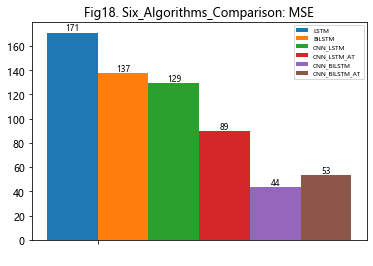

In [75]:
# 绘制6种算法的估值比较图
#import matplotlib
#import matplotlib.pyplot as plt
#import numpy as np

def drawHistogram(title, num):
    matplotlib.rc("font", family='MicroSoft YaHei')
    
    list1 = np.array([MSE_error_LSTM])   # 柱状图第一组数据
    list2 = np.array([MSE_error_BI])   # 柱状图第二组数据
    list3 = np.array([MSE_error_CL])   # 柱状图第三组数据
    list4 = np.array([MSE_error_CLA])   # 柱状图第四组数据
    list5 = np.array([MSE_error_CB])   # 柱状图第五组数据
    list6 = np.array([MSE_error_CBA])   # 柱状图第六组数据
    
    length = len(list1)
    x = np.arange(length)   # 横坐标范围
    x_label = [" "]

    plt.figure()
    total_width, n = 2.4 , 6   # 柱状图总宽度，有几组数据
    width = total_width / n   # 单个柱状图的宽度
    x1 = x - width / 2   # 第一组数据柱状图横坐标起始位置
    x2 = x1 + width   # 第二组数据柱状图横坐标起始位置
    x3 = 2*width + x1
    x4 = 3*width + x1
    x5 = 4*width + x1
    x6 = 5*width + x1
    # 标题
    plt.title('Fig'+num+'. '+title)

    plt.bar(x1, list1, width=width, label="LSTM")
    plt.bar(x2, list2, width=width, label="BILSTM")
    plt.bar(x3, list3, width=width, label="CNN_LSTM")
    plt.bar(x4, list4, width=width, label="CNN_LSTM_AT")
    plt.bar(x5, list5, width=width, label="CNN_BILSTM")
    plt.bar(x6, list6, width=width, label="CNN_BILSTM_AT")
    
    for a, b in zip(x1, list1):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)

    for a, b in zip(x2, list2):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)
    
    for a, b in zip(x3, list3):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)

    for a, b in zip(x4, list4):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)
    
    for a, b in zip(x5, list5):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)

    for a, b in zip(x6, list6):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)

    plt.xticks(x, x_label)   
    # 给出图例
    plt.legend(loc=1, prop={'size': 6})
    
    
    # 保存于 file/
    #savingPath = 'file/Fig'+num+'_'+title.replace(' ', '_')+'.png'
    #plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    drawHistogram(title = 'Six_Algorithms_Comparison: MSE', num = '18')

### 从Fig18来看，CNN_BILSTM_AT 在一年的预测中表现最佳

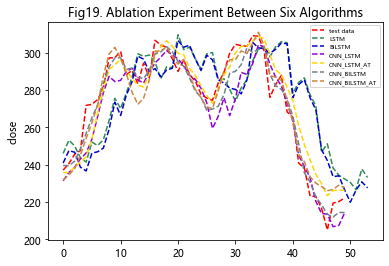

In [77]:
ablation_exp(inv_yPredict_LSTM, inv_yPredict_BI, inv_yPredict_CL, inv_yPredict_CLA, inv_yPredict_CB, inv_yPredict_CBA, inv_yTest_CBA, title='Ablation Experiment Between Six Algorithms', num='19')